In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date
from tqdm import tqdm_notebook

In [3]:
'''
Import data, previously downloaded by the script 00_addcontr_get_data
'''

data_addcontr = pd.read_excel('02_data/00_data_addcontr_all_v5.xlsx','Sheet1')
print(data_addcontr.shape)
print(data_addcontr.columns)

data_addcontr.loc[:,'date_signed'] = pd.to_datetime(data_addcontr['date_signed']).map(lambda x: x.date())
data_addcontr.loc[:,'addcontr_date'] = data_addcontr['addcontr_date'].map(lambda x: pd.to_datetime(x).date() if x != 'unknown' else x)
data_addcontr['contract_start'] = data_addcontr.loc[:,'contract_start'].map(lambda x: pd.to_datetime(x).date() if x != 'not specified' else x)
data_addcontr['contract_end'] = data_addcontr.loc[:,'contract_end'].map(lambda x: pd.to_datetime(x).date() if x != 'not specified' else x)

data_addcontr.head(3)

(24524, 19)
Index(['contract_id', 'date_signed', 'procuring_entity', 'procuring_entity_id',
       'procuring_entity_type', 'region', 'contract_value', 'quantity',
       'units', 'item_desc', 'cpv', 'contract_start', 'contract_end',
       'addcontr_date', 'rationale_type', 'rationale', 'tender_id',
       'procurement_type', 'tenderURL'],
      dtype='object')


,contract_id,date_signed,procuring_entity,procuring_entity_id,procuring_entity_type,region,contract_value,quantity,units,item_desc,cpv,contract_start,contract_end,addcontr_date,rationale_type,rationale,tender_id,procurement_type,tenderURL
0,244af7a6ee364ed3a8b3cff3cedabc3f,2017-08-01,"Державний вищий навчальний заклад ""Університет...",34716922,general,Київська область,1093519.824,162450,MTQ,Природний газ для потреб Львівського навчально...,09120000-6,2017-08-01,2017-12-31,2017-10-11,"volumeCuts, itemPriceVariation",Згідно довідки Торгово-промислової палати Укра...,UA-2017-05-15-002292-b,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-05-15-0...
1,28cf7ff64b564839b13c8c91c98676dc,2017-08-02,Квартирно - експлуатаційний відділ м. Херсона,8294952,general,Херсонська область,1124468.370,202501,MTQ,Природний газ,09120000-6,2017-08-02,2017-12-31,2017-08-29,volumeCuts,Зменшення обсягів закупівлі з метою приведення...,UA-2017-06-21-000460-b,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-06-21-0...
2,28cf7ff64b564839b13c8c91c98676dc,2017-08-02,Квартирно - експлуатаційний відділ м. Херсона,8294952,general,Херсонська область,1124468.370,202501,MTQ,Природний газ,09120000-6,2017-08-02,2017-12-31,2017-09-20,itemPriceVariation,Підвищення вартості природного газу на ринку У...,UA-2017-06-21-000460-b,aboveThresholdUA,https://prozorro.gov.ua/tender/UA-2017-06-21-0...


In [7]:
'''
Create table with duration of each contract,
starting from 2017-08-01 and ending no later than 2018-12-31
'''
contract_dates = data_addcontr.drop_duplicates(subset = 'contract_id')[['contract_start','contract_end']]
contract_dates = contract_dates.loc[(contract_dates['contract_start']!='not specified')&(contract_dates['contract_end']!='not specified')].sort_values(by = ['contract_start'])
contract_dates = contract_dates.loc[(contract_dates['contract_start']>=date(2017,8,1))&(contract_dates['contract_end']<=date(2018,12,31))]
print(len(contract_dates))
contract_dates.head()

3647


,contract_start,contract_end
19572,2017-08-01,2017-12-31
378,2017-08-01,2017-12-31
123,2017-08-01,2018-01-31
107,2017-08-01,2017-12-31
0,2017-08-01,2017-12-31


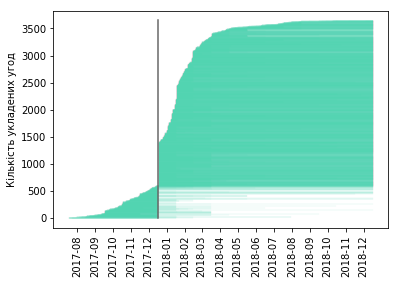

In [8]:
'''
Vizualize contract durations:
each line is one contract
'''

for i in tqdm_notebook(range(len(contract_dates))):
    x, y = [contract_dates.iloc[i,:][0], contract_dates.iloc[i,:][1]], [i, i]
    plt.plot(x, y, color = '#3fd4ad', linewidth = 0.1)
    
mode = contract_dates['contract_end'].mode()[0]
x_vert1, y_vert1 = [date(2017,12,31), date(2017,12,31)], [0,len(contract_dates)]

plt.plot(x_vert1, y_vert1, color  = '#666666')

ticks = [date(2017,month,15) for month in range(8,13)]
ticks = ticks + [date(2018,month,15) for month in range(1,13)]
labels = ['%s-%s' % (tick.year, ('0' + str(tick.month))[-2:]) for tick in ticks]

plt.xticks(ticks, labels, rotation='vertical')
plt.ylabel('Кількість укладених угод')
#plt.savefig('01_visuals/contracts_duration_all_2018-11-13.png', dpi=300, bbox_inches = 'tight')
plt.show()

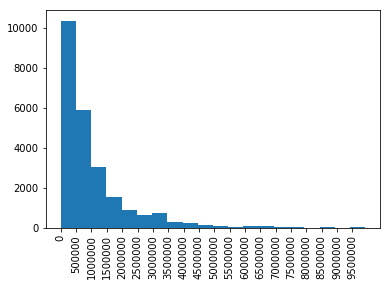

269


In [9]:
'''
Distribution of contract values
Contracts for more than 10 mln UAH are filtered out as outliers
'''
plt.hist(data_addcontr.loc[data_addcontr['contract_value']<10**7]['contract_value'], bins = 20)
ticks = [(i*10**6)/2 for i in range(20)]
plt.xticks(ticks, rotation='vertical')
#plt.yscale('log')
plt.show()
data_addcontr['contract_value']
print(len(data_addcontr.loc[data_addcontr['contract_value']>10**7]))

In [11]:
'''
Function for creating description for different contact value thresholds
'''
def printouts(threshold, data_addcontr):
    contracts_all = data_addcontr['contract_id']
    contracts = data_addcontr.loc[data_addcontr['contract_value']>threshold]
    contracts_unique = contracts.drop_duplicates(subset='contract_id')
    contracts_sum = contracts_unique['contract_value'].sum()
    contracts_sum_all = data_addcontr.drop_duplicates(subset='contract_id')['contract_value'].sum()
    
    print("При порозі %s грн доведеться опрацювати %i додугод до %i договорів" %(threshold,len(contracts),len(contracts_unique)))
    print("Це %.2f%% від усіх додугод та %.2f%% від усіх договорів" %(len(contracts)/len(contracts_all)*100,len(contracts_unique)/len(contracts_all.unique())*100))
    print("Сума опрацьованих угод за таких умов %.2f млн грн, що становить %.2f%% від загальної суми" %(contracts_sum/10**6,contracts_sum/contracts_sum_all*100))

In [12]:
#threshold 200 000 UAH (official procurement threshold in most cases)
printouts(2*10**5, data_addcontr)

При порозі 200000 грн доведеться опрацювати 20441 додугод до 3291 договорів
Це 83.35% від усіх додугод та 74.90% від усіх договорів
Сума опрацьованих угод за таких умов 5619.07 млн грн, що становить 97.91% від загальної суми


In [13]:
#threshold 500 000 UAH
printouts(5*10**5, data_addcontr)

При порозі 500000 грн доведеться опрацювати 14091 додугод до 2176 договорів
Це 57.46% від усіх додугод та 49.52% від усіх договорів
Сума опрацьованих угод за таких умов 5236.25 млн грн, що становить 91.24% від загальної суми


In [14]:
#threshold 1 000 000 UAH, which is chosen as optimal threshold for further analysis
printouts(10**6, data_addcontr)

При порозі 1000000 грн доведеться опрацювати 8250 додугод до 1207 договорів
Це 33.64% від усіх додугод та 27.47% від усіх договорів
Сума опрацьованих угод за таких умов 4551.86 млн грн, що становить 79.31% від загальної суми


In [15]:
#threshold 2 000 000 UAH
printouts(2*10**6, data_addcontr)

При порозі 2000000 грн доведеться опрацювати 3661 додугод до 534 договорів
Це 14.93% від усіх додугод та 12.15% від усіх договорів
Сума опрацьованих угод за таких умов 3616.13 млн грн, що становить 63.01% від загальної суми


In [16]:
'''
Export data to contract with value exceeding 1 mln UAH
'''
data_addcontr_filtered = data_addcontr.loc[data_addcontr['contract_value']>10**6]
print(data_addcontr_filtered.shape)
data_addcontr_filtered.to_excel('02_data/addcontr_gas_1mln_v2.xlsx', index = False)

(8250, 19)
